In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# https://towardsdatascience.com/a-deep-learning-approach-in-predicting-the-next-word-s-7b0ee9341bfe
import nltk
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# read-in cleaned data and parse.
# path = '../data/'
#path = '/content/drive/MyDrive/Colab Notebooks/'
path = '/content/'
filepath = path + 'allphishsets.csv'

df = pd.read_csv(filepath)
df = df.sort_values(by=['showdate', 'set', 'position'],
                    ascending=[True, True, True])

df.loc[df['times_played'] <= 2, 'slug'] = 'wildcard'
df.loc[df['times_played'] <= 2, 'times_played'] = 510

songstring = df[['showdate', 'set', 'slug']].groupby(['showdate', 'set'])['slug']\
                                            .apply(lambda x: '|'.join(x)).reset_index()
songstring['full'] = songstring.apply(lambda row: f"set-{row['set']}|{row['slug']}", axis=1)

songstring = songstring[['showdate', 'full']].groupby(['showdate'])['full']\
                                             .apply(lambda x: '|'.join(x)).reset_index()

songstring['full'] += '|eos'

In [2]:
# NLP the setlists via n-gram model
corpus = [''.join(map(lambda s: s.replace('|', ' '), f))
          for f in songstring['full']]

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
unique_words = len(tokenizer.word_index) + 1

max_seq_length = max([len(setlist.split(' ')) for setlist in corpus]) - 1

def NGramSequences(corpus: list, tokenizer: Tokenizer, max_seq_length=None):
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(0, len(token_list)):
            n_gram_seqs = token_list[:i+1]
            input_sequences.append(n_gram_seqs)
    if max_seq_length is None:
        max_seq_length = max([len(x) for x in input_sequences])
    input_seqs = np.array(
        pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre')
    )
    return input_seqs

input_seqs = NGramSequences(
    corpus=corpus, tokenizer=tokenizer, max_seq_length=max_seq_length
)

x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
y_values = tf.keras.utils.to_categorical(labels,
                                         num_classes=unique_words)

# get directed graph adjacency matrix as embeddings matrix
corpus_list = [
    song for songs in
    [setlist.split(' ') for setlist in corpus]
    for song in songs
]

tw_idx = tokenizer.word_index

coocurrence_matrix = np.zeros((unique_words, unique_words))
for i in trange(len(corpus_list)):
    if i == 0:
        continue
    song_a = tw_idx[corpus_list[i-1]]
    song_b = tw_idx[corpus_list[i]]
    coocurrence_matrix[song_a][song_b] += 1

# Laplace smooth
coocurrence_matrix += 1
embeddings_matrix = coocurrence_matrix / np.sum(coocurrence_matrix, axis=1, keepdims=True)

100%|██████████| 39849/39849 [00:00<00:00, 425142.50it/s]


In [3]:
K.clear_session()

batch_size=1024

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=unique_words, output_dim=unique_words,
        weights=[embeddings_matrix], input_length=input_seqs.shape[1]-1,
        trainable=False
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(unique_words, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

early_stop = EarlyStopping(
    monitor='val_accuracy', patience=20, min_delta=0.0001, mode='max',
    start_from_epoch=10, restore_best_weights=True
)

history = model.fit(
    x_values, y_values,
    epochs=120, batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/120
32/32 [==============================] - 35s 412ms/step - loss: 5.4584 - accuracy: 0.0359 - val_loss: 5.9437 - val_accuracy: 0.0413
Epoch 2/120
32/32 [==============================] - 12s 367ms/step - loss: 5.1201 - accuracy: 0.0396 - val_loss: 6.0496 - val_accuracy: 0.0412
Epoch 3/120
32/32 [==============================] - 12s 365ms/step - loss: 5.1132 - accuracy: 0.0383 - val_loss: 6.1047 - val_accuracy: 0.0753
Epoch 4/120
32/32 [==============================] - 12s 379ms/step - loss: 5.1077 - accuracy: 0.0389 - val_loss: 6.0746 - val_accuracy: 0.0413
Epoch 5/120
32/32 [==============================] - 12s 379ms/step - loss: 5.1032 - accuracy: 0.0401 - val_loss: 6.1496 - val_accuracy: 0.0412
Epoch 6/120
32/32 [==============================] - 12s 375ms/step - loss: 5.0979 - accuracy: 0.0414 - val_loss: 6.1343 - val_accuracy: 0.0412
Epoch 7/120
32/32 [==============================] - 12s 371ms/step - loss: 5.0575 - accuracy: 0.0532 - val_loss: 6.0137 - val_accuracy:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 491)           241081    
                                                                 
 bidirectional (Bidirection  (None, 54, 512)           1531904   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               1574912   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               6

Text(0.5, 1.0, 'Next Song Accuracy')

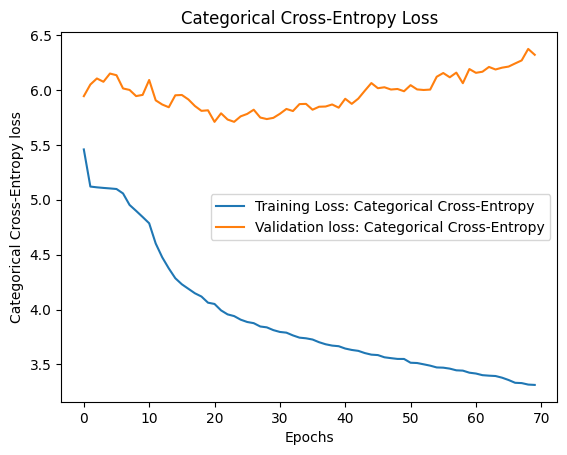

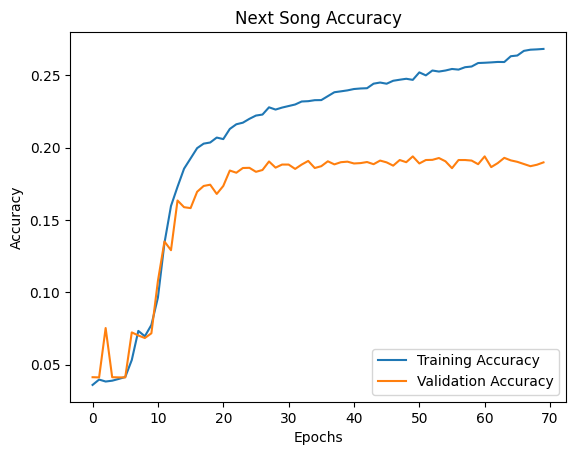

In [5]:
print(model.summary())

loss = 'Categorical Cross-Entropy'

plt.figure()
plt.plot([ l for l in history.history['loss'] ],
         label=f'Training Loss: {loss}')
plt.plot([ l for l in history.history['val_loss'] ],
         label=f'Validation loss: {loss}')

plt.xlabel('Epochs')
plt.ylabel(f'{loss} loss')
plt.legend(loc='center right')
plt.title(f"{loss} Loss")

plt.figure()
plt.plot([ l for l in history.history['accuracy'] ],
         label=f'Training Accuracy')
plt.plot([ l for l in history.history['val_accuracy'] ],
         label=f'Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel(f'Accuracy')
plt.legend(loc='lower right')
plt.title("Next Song Accuracy")

In [6]:
import numpy as np

def generate_predictions(model,org_list, tokenizer, seed_length):
    #predicted_sequence = seed_text.split()
    seed_sequence = org_list[:seed_length]
    predicted_sequence = seed_sequence.copy()
    unique_tokens = set([tokenizer.word_index[word] for word in predicted_sequence])
    max_length = len(org_list) - seed_length
    i = 0
    while i < max_length:
        token_list = [tokenizer.word_index[word] for word in predicted_sequence]
        token_list = pad_sequences([token_list], maxlen=max_seq_length-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)[0]

        # Exclude songs that have already been predicted
        if predicted in unique_tokens:
          i -=1
            #break

        predicted_sequence.append(tokenizer.index_word[predicted])
        unique_tokens.add(predicted)
        i += 1

    return predicted_sequence


#org_list = corpus[-1].split()
org_list = ['farmhouse', 'first-tube', 'twist', 'divided-sky', 'ginseng-sullivan', 'carini', 'whats-the-use', 'wildcard', 'set-2', 'down-with-disease', 'the-moma-dance', 'piper', 'fee', 'gotta-jibboo', 'saw-it-again', 'split-open-and-melt', 'cavern', 'david-bowie', 'set-e', 'the-squirming-coil', 'eos']

seed_length = 3
predicted_sequence = generate_predictions(model,org_list, tokenizer, seed_length)
print("Originial Sequence",org_list)
print("Seed Sequence",org_list[:seed_length])
print("Predicted Sequence:", set(predicted_sequence))


1/1 [==============================] - 0s 25ms/step
Originial Sequence ['farmhouse', 'first-tube', 'twist', 'divided-sky', 'ginseng-sullivan', 'carini', 'whats-the-use', 'wildcard', 'set-2', 'down-with-disease', 'the-moma-dance', 'piper', 'fee', 'gotta-jibboo', 'saw-it-again', 'split-open-and-melt', 'cavern', 'david-bowie', 'set-e', 'the-squirming-coil', 'eos']
Seed Sequence ['farmhouse', 'first-tube', 'twist']
Predicted Sequence: {'you-enjoy-myself', 'stash', 'wildcard', 'first-tube', 'set-2', 'sparkle', 'cavern', 'silent-in-the-morning', 'tweezer', 'sleeping-monkey', 'the-lizards', 'twist', 'farmhouse', 'lifeboy', 'set-e', 'also-sprach-zarathustra', 'david-bowie', 'the-horse', 'eos', 'bouncing-around-the-room', 'runaway-jim'}


In [7]:
# Assuming org_list, seed_sequence, stopword_list, and predicted_sequence are lists of songs


stopword_list = {}
# Convert the lists to sets
org_set = set(org_list)
seed_set = set(org_list[:seed_length])

# Find the songs in org_list but not in seed_sequence
not_in_seed_sequence = org_set - seed_set

# Remove songs in stopword_list
filtered_songs = [song.strip() for song in not_in_seed_sequence if song not in stopword_list]

# Remove songs in stopword_list from predicted_sequence
predicted_sequence = [song.strip() for song in predicted_sequence[seed_length:] if song not in stopword_list]

# Count the number of matching songs
matching_songs = [song for song in filtered_songs if song in predicted_sequence]
num_matching_songs = len(matching_songs)

# Calculate the percentage of matching songs
percentage_matching = (num_matching_songs / len(filtered_songs)) * 100

print("Matching Songs in Predicted Sequence:")
print(matching_songs)
print("Number of Matching Songs:", num_matching_songs)
print("Percentage of Matching Songs:", percentage_matching)

Matching Songs in Predicted Sequence:
['wildcard', 'set-2', 'set-e', 'david-bowie', 'cavern', 'eos']
Number of Matching Songs: 6
Percentage of Matching Songs: 33.33333333333333
